# Assumptions

This section will walk through the assumptions and setup of linear regression in a single dimension. Everything discussed here can be extended to multiple dimensions.

## The Problem
Linear regression is, well linear. When we apply linear regression, we assume that the data has some type of underlying linear relationship that we model. What does this mean? Well the random variable representing our output $Y$, is linearly related to our input random variable $X$ by a constant factor $\theta$. However, the system isn't perfect, and thus doesn't perfectly follow an exact linear relationship. We account for these errors or randomness by including an extra random variable $\epsilon$, representing the error. This yields the following relationship:

$$Y = \theta X + \epsilon$$

That's it. Our goal is to create a model of this relationship using data. The data distribution $p_{data}$ is defined by the joint distribution over $X, Y$. In the field of probablistic inference, it's often assumed that you have access to the data distribution, and thus can solve for the exact relationship using the probablitity distributions of $X$ and $Y$. We, however, are interested in learning from data, and instead use an emperical estimate of $p_{data}$ by collecting $N$ samples from the joint distribution, $\{(x_i, y_i)\}_{i=1}^N$. Note that here we are assuming that the errors are distributed the same for every collected data point, as each $\epsilon_i$ comes from the same distribution. Our goal is then to find the value $\theta$ that yields the highest probability of correctly guessing the value of $Y$ given the value of $X$. 

So, we can estimate $p_{data}$ using samples and we want to find $\theta$, but what about $\epsilon$? Each sample point we collect will have some deviation $\epsilon_i$ away from the true linear relationship. How should we model these errors?

## The Error Model
It turns out that we only need to make two assumptions about errors in order to derive a distribution for $\epsilon$. 
1. We need to assume that the error $\epsilon$ is actually a cumulative sum of many independent error factors $\epsilon^{(1)}, ..., \epsilon^{(m)}$. Precisely, $\epsilon = \epsilon^{(1)} +  \epsilon^{(2)} + ... + \epsilon^{(m)}$ and that $m \rightarrow \infty$.
2. For each of the error factors $\epsilon^{(j)}$, $E[\epsilon^{(j)}] = 0$, or the average of each error is zero (no error).

Let's start by examining the second assumption. This implies that $E[\epsilon] = E[\epsilon^{(1)} + ... + \epsilon^{(m)}] = E[\epsilon^{(1)}] + ... + E[\epsilon^{(m)}] = 0 + ... + 0 = 0$. This means that the expected error is zero. And thus in expectation, we get the exact linear relationship: $E[Y] = \theta E[X] + 0$. Whatever the distribution of $\epsilon$ is, we expect it to have mean zero.

There are many continuous probability distributions with expection zero that could each be an $\epsilon^{(j)}$. In fact, they don't even need to have a closed mathematical form. Here, we'll make an arugment based on the uniform interval between -1 and 1, but know that the same argument applies to any distribution. Let's assume that each of the error sources follows this distribution:

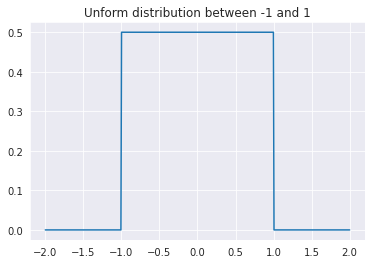

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy import signal
import seaborn as sns
import numpy as np

uniform_dist = stats.uniform(loc=-1, scale=2)

x = np.linspace(-2, 2, 500)
y = uniform_dist.pdf(x)
sns.set_style("darkgrid")
sns.lineplot(x, y)
_ = plt.title("Unform distribution between -1 and 1")

However, that's just one of the error factors, we have $k$ of them! What we care about is the distribution of $\epsilon^{(1)} +  \epsilon^{(2)} + ... + \epsilon^{(m)}$. Let's start with just $\epsilon^{(1)} +  \epsilon^{(2)}$. Intuitively, we can see that the minimum possible is -2 while the maximum value is 2. However, what about everything else? What we care about is $P(\epsilon^{(1)} +  \epsilon^{(2)} \in [k, k+\delta]), where $\delta$ is some infentily small value. We find this value as follows:

$$P(\epsilon^{(1)} +  \epsilon^{(2)} \in [k, k+\delta]) = \int_{-\infty}^\infty f_{\epsilon^{(2)} | \epsilon^{(1)}} (\epsilon^{(1)} +  \epsilon^{(2)} = k | \epsilon^{(1)} = t) f_{\epsilon^{(1)}}(t) dt = \int_{-\infty}^\infty f_{\epsilon^{(2)}} (k - t) f_{\epsilon^{(1)}}(t) dt $$

We first argue that the probability of being in $[k, k+\delta]$ is given by the sum of all of the different combinations of $\epsilon^{(1)}$ and $\epsilon^{(2)}$ such that their sum belongs to that region. As such, we integrate over all possible values. Next, we seperate the joint probability into conditionals and finally apply independence to seperate the pdfs of each random variable. The argument essentially boils down the this: we consider all values of $\epsilon^{(1)}$ and the probability of $\epsilon^{(1)}$ taking a value $t$, and multiply that by the probability that $\epsilon^{(2)}$ is $k - t$ or the exactly value needed to make the sum $k$. Visually, the convolution of two of the unform distributions depicted above looks like this:

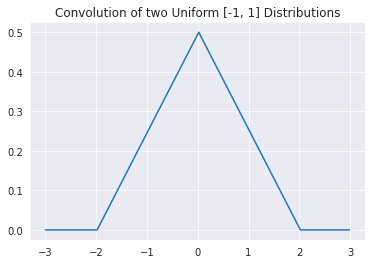

In [3]:
delta = 1e-2
x = np.arange(-3,3, delta)
uniform_dist = stats.uniform(loc=-1, scale=2)
pdf = uniform_dist.pdf(x)
pmf = pdf*delta 

conv_pmf = signal.fftconvolve(pmf,pmf,'same')
conv_pdf = conv_pmf / delta

plt.plot(x,conv_pdf)
plt.title("Convolution of two Uniform [-1, 1] Distributions")
plt.show()

Now, let's convolve together $m$ different zero mean error distributions and see what happens!

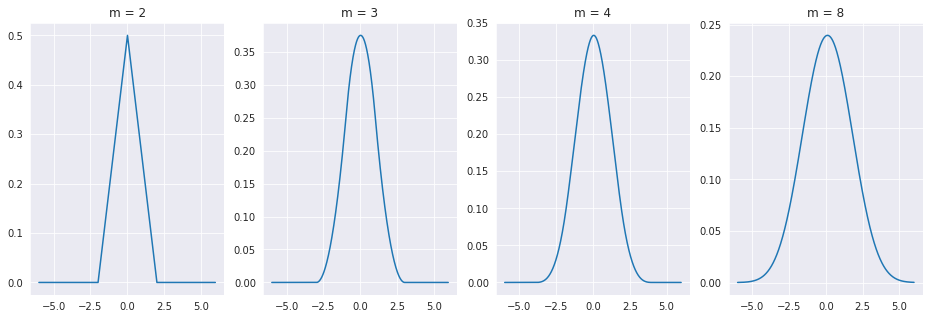

In [28]:
delta = 1e-2
x = np.arange(-6,6, delta)

m_list = [2, 3, 4, 8]
fig, ax = plt.subplots(1,len(m_list), figsize=(16,5))

pdf = uniform_dist.pdf(x)
for i, m in enumerate(m_list):
    output = pdf.copy()
    for _ in range(m-1):
        output = signal.fftconvolve(output*delta,pdf*delta,'same')/delta
    g = sns.lineplot(x=x, y=output, ax=ax[i])
    g.set_title("m = " + str(m))
plt.show()

We can also try doing this with randomly sized uniform intervals, or even very strange pdfs, and the result will be the same.

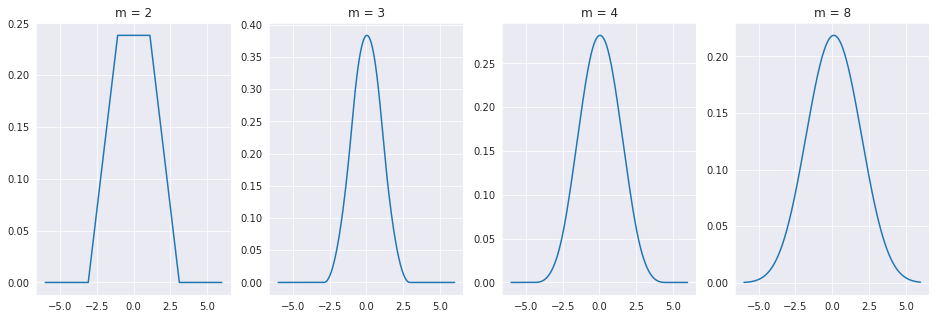

In [29]:
delta = 1e-2
x = np.arange(-6,6, delta)

m_list = [2, 3, 4, 8]
fig, ax = plt.subplots(1,len(m_list), figsize=(16,5))

for i, m in enumerate(m_list):
    r = 5*np.random.rand()
    output = stats.uniform(loc=-r/2, scale=r).pdf(x)
    for _ in range(m-1):
        r = 5*np.random.rand()
        new_pdf = stats.uniform(loc=-r/2, scale=r).pdf(x)
        output = signal.fftconvolve(output*delta,pdf*delta,'same')/delta
    g = sns.lineplot(x=x, y=output, ax=ax[i])
    g.set_title("m = " + str(m))
plt.show()

In [30]:
delta = 1e-2
x = np.arange(-6,6, delta)

m_list = [1, 5, 15, 25, 50]
fig, ax = plt.subplots(1,len(m_list), figsize=(16,5))


pdf = np.array([1 if (abs(v) > 0.5 and abs(v) < 1) else 0 for v in x ])

for i, m in enumerate(m_list):
    output = pdf.copy()
    for _ in range(m-1):
        output = signal.fftconvolve(output*delta,pdf*delta,'same')/delta
    g = sns.lineplot(x=x, y=output, ax=ax[i])
    g.set_title("m = " + str(m))
plt.show()

As you might expect, this result holds for any type distribution you use! As the sum of all of the error sources tend towards this bell shaped distribution, we should use that to model the error $\epsilon$. It turns out, that according to a famous theorem from probability theory called the *Central Limit Theorem*, the sum of independent random variables tends towards a normal, or gaussian, distribution. The one dimensional guassian pdf is as follows.

$$ f_X(x) = \frac{1}{\sqrt{2\pi} \sigma} e^{-\frac{(x - \mu)^2}{2\sigma^2}}$$

Where $\mu$ is the mean or expectatn of the distribution and $\sigma^2$ is the variance. We often write down normal distributions as $\mathcal{N}(\mu, \sigma^2)$. As our error has an expectation of zero, $\epsilon \sim \mathcal{N}(0,\sigma^2)$. We now can write down the final problem.

**The 1D Linear Regression Formulation**

Given data points $\{(x_i, y_i)\}_{i=1}^N$ such that $Y = \theta X + \epsilon$ where $\epsilon \sim \mathcal{N}(0,\sigma^2)$, determine the value of $\theta$ that maximizes the probability of guessing the correct value of $Y$ given $X$.

In the next section, we'll explain how to solve this problem mathematically.